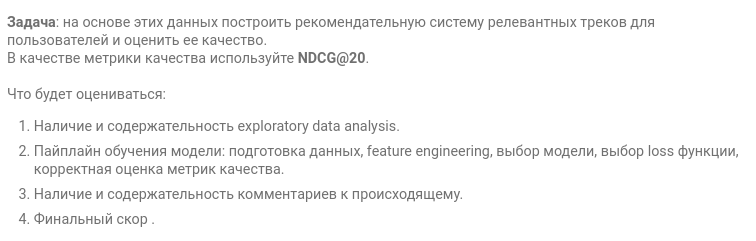

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sup import autoLabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import ndcg_score

In [2]:
df_target = pd.read_csv("data/train.csv")
df_members = pd.read_csv("data/members.csv")
df_songs = pd.read_csv("data/songs.csv")

### Исследование

In [3]:
df_target.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


Инторпретация target:\
пусть 1 песня понравилась пользователю (так как он послушал ее дважды).\
0 не понравилась.

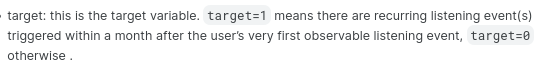

<Axes: xlabel='target', ylabel='Count'>

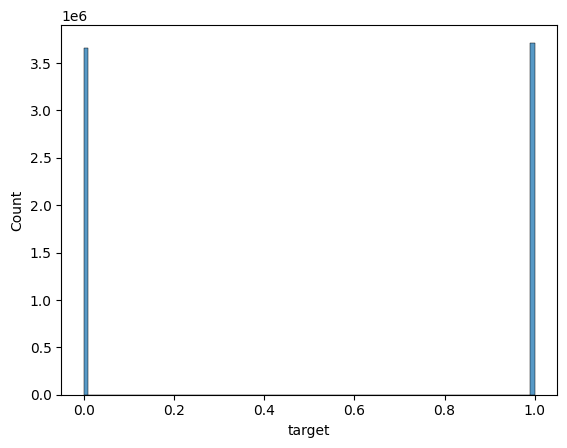

In [4]:
sns.histplot(df_target, x="target")

Можем сделать вывод что target распределен равномерно.

In [5]:
df_target["msno"].value_counts().describe()

count    30755.000000
mean       239.877028
std        314.130788
min          1.000000
25%         27.000000
50%        128.000000
75%        340.000000
max       5819.000000
Name: count, dtype: float64

Делаем вывод о количестве прослушанных песен для пользователей.

In [6]:
print(df_songs.isna().sum())

song_id              0
song_length          0
genre_ids        94116
artist_name          0
composer       1071358
lyricist       1945306
language             1
dtype: int64


In [7]:
print(df_members.isna().sum())

msno                          0
city                          0
bd                            0
gender                    19902
registered_via                0
registration_init_time        0
expiration_date               0
dtype: int64


Имеем null значения, которые нужно обработать.

### feature инженеринг
Много карегориальных переменных одна из идей от даты оставить только год.

In [8]:
df_members["registration_init_time"] = df_members["registration_init_time"].apply(lambda q: q//10000)

Некоторые жанры песен имеют несколько значений. Можно было разделить их на отдельные столбцы, но мы хотим оставить их в первичном виде, чтобы рассмотреть каждую перестановку. (возможно не очень хорошая идея нужно доп исследование)

Если смотреть на другие переменные, то мы имеем много категориальных признаков, довольно сложно придумать что можно сделать с этими признаками.

### Предобработка данных

объединим все данные в одну таблицу (не очень правильно, но нужно для модели).

In [9]:
df_uni = df_target.join(df_members.set_index("msno"),on="msno")
df_uni = df_uni.join(df_songs.set_index("song_id"),on="song_id")
df_uni.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,NaN,7,2012,20171005,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011,20170911,284584.0,1259,Various Artists,NaN,NaN,52.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011,20170911,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011,20170911,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,NaN,7,2012,20171005,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0


In [10]:
df_uni = df_uni.drop("expiration_date",axis=1)

In [11]:
df_uni.shape

(7377418, 17)

значений получилось очень много для обучения на персональном пк, попробуем уменьшить датасет для проведения эксперементов.

In [12]:
df_uni = df_uni.dropna()

In [13]:
df_uni.shape

(2344883, 17)

Выбрасывать nan является плохой практикой, изначально нужно попытаться восстановить через модели ml или записать статстические данные, но датасет позволяет* отбросить для проведения эксперемента

In [14]:
temp = df_uni["msno"].value_counts()
selected =  temp[temp >= 1000].index
df_uni = df_uni[df_uni["msno"].isin(selected)]


Здесь мы попытались оставить пользователей для которых имеется больше 1000 записей, чтобы вычислять метрику было более конструктивно.

In [15]:
df_uni.shape

(85467, 17)

Для категориальных признаков воспользуемся lable encoder т.к. onehot encoder из за большого датасета с разнообразными значениями будет очень сильно увеличивать размерность данных.

In [16]:

ale = autoLabelEncoder()

cat = list(df_uni.select_dtypes("object").columns)
ale.fit(df_uni, cat)
df_uni = ale.transform(df_uni, cat)

df_uni.head()

msno
song_id
source_system_tab
source_screen_name
source_type
gender
genre_ids
artist_name
composer
lyricist


,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,song_length,genre_ids,artist_name,composer,lyricist,language
155,55,15163,3,7,2,1,13,32,0,9,2004,226324.0,79,1992,6196,6157,3.0
157,55,629,3,7,2,1,13,32,0,9,2004,306528.0,79,1633,7078,7178,3.0
641,10,10836,3,7,3,1,13,26,0,3,2015,283678.0,82,2853,7409,7535,3.0
642,10,7630,3,7,3,1,13,26,0,3,2015,272718.0,82,2056,5222,6695,3.0
643,10,15003,3,7,3,1,13,26,0,3,2015,217234.0,82,2056,5835,6695,3.0


In [17]:

X = df_uni.drop(["target"],axis=1)
y = df_uni["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Построение recsys

Представим оценку пользователя как некоторую функцию от вектора признаков фильма и признаков пользователя. Получим матрицу, где на позиции $ij$ стоит оценка пользователя $j$ для фильма $i$. Наша задача восстановить эту функцию по имеющимся значениям в матрице.

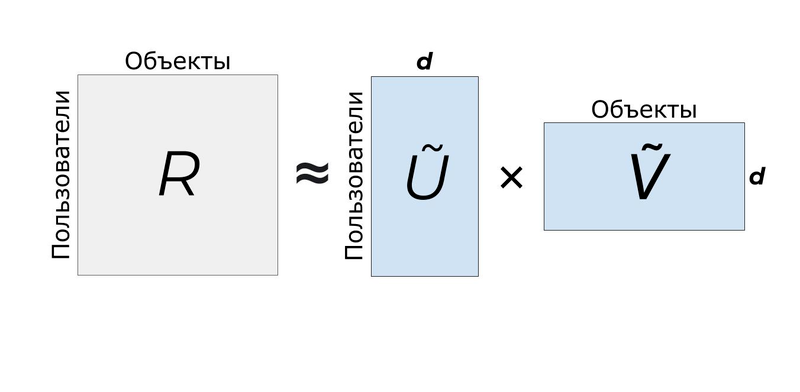

Затем ранжируем эти значения по убыванию.

### Выбор модели

Сначала пробовалось обучать логистическую регрессию для 2ух млн. данных. Результаты не высокие. Делаем вывод что данные имеют нелинейную зависимость.

Предлагается использовать бустинговый случайный лес. Т.к модель показывает хорошую точность на нелинейных задачах за приемлимое время обучения.

loss: logloss, потому что понятная статистическая интерпритация вероятности класса.

In [18]:

gb_clf = GradientBoostingClassifier(max_depth=20, loss="log_loss")
gb_clf.fit(X_train.drop(["msno","song_id"],axis=1), y_train)

GradientBoostingClassifier(max_depth=20)

In [19]:
print(gb_clf.score(X_test.drop(["msno","song_id"], axis=1), y_test))

0.6581841581841582


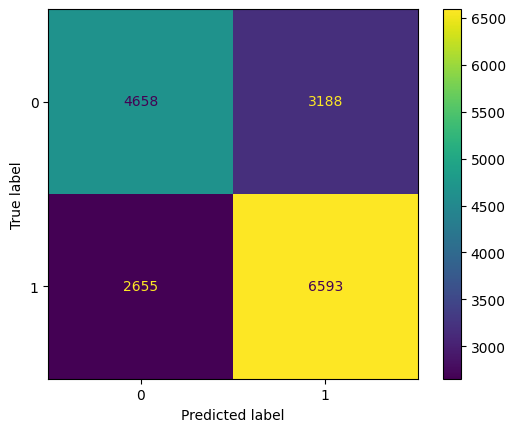

In [22]:

cm = confusion_matrix(y_test, gb_clf.predict(X_test.drop(["msno","song_id"], axis=1)))
ConfusionMatrixDisplay(cm).plot()

Здесь нас интересует левый нижний угол, т.к плохим является предсказание если мы предложим пользователю не интресный трек. Если мы не покажем интресную это не такая большая проблема. Хотя в идельном случае мы хотим минимизировать оба этих блока.

### Оценка метрики

Для каждого пользователя из тестовой выборки найдем ранжировку предложенную моделью (сортировка по предсказаниям модели). Затем посчитаем NDCG@20 для исходных данных расставленных правильно и раставленных моделью.
В конце выведем среднее значение по всем пользователям.

In [25]:

itr = 0
scores = []
for usr in list(pd.unique(X_test["msno"])):
    rec = []
    for sng in list(X_test[X_test["msno"] == usr]["song_id"]):
        rec.append((sng, *gb_clf.predict(X_test[(X_test["msno"] == usr) & (X_test["song_id"] == sng)].drop(["msno","song_id"],axis=1)), list(y_test)[itr]))
        itr += 1
    y_true = [sorted([i[2] for i in rec])]
    rec = sorted(rec, key=lambda q: q[1], reverse= True)
    y_pred = [[i[2] for i in rec]]
    scores.append(ndcg_score(y_true=y_true, y_score=y_pred, k=20))

print(np.mean(scores))

0.5427022474797967


### Интерпритация результатов

Значение метрики не очень высокое, но при этом мы имеем значительный запас данных, а значит упор идет в модель или качество данных. Предлагается провести глубокое исследование данных, например, регриссионный анализ. Также обучить обучить более масштабную модель - нейронную сеть. 

Также можно предположить, что низкие результаты связаны с построением датасета, т.к изначально требовалось предсказать послушает ли пользователь песню 2ой раз.